In [24]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
STOPWORDS = stopwords.words('english')
STOPWORDS =  STOPWORDS  + ['comma', 'na', 'dynamic', 'name', 'aadv']

In [5]:
def preprocess_text(text, stop_words = STOPWORDS):
    # Convert to lowercase
    text = str(text).lower()
    # text = re.sub(r'http\S+|www\S+|https\S+', ' ', str(text), flags=re.MULTILINE)

    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = re.sub(r'_', ' ', str(text))
    text = re.sub(r'71095826-bf22-49bd-9678-7d89ec4f6d49', '', text) 

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " ", text)

    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = re.sub(r'\{[^}]*\}', '', text)

    # Remove stop words
    word_tokens = word_tokenize(text)
    text = ' '.join([w for w in word_tokens if w not in stop_words])

    # Remove words with only two letters
    text = ' '.join([w for w in text.split() if len(w) > 2])

    # Stemming
    stemmer = PorterStemmer()
    word_list = word_tokenize(text)
    text = ' '.join([stemmer.stem(w) for w in word_list])

    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = word_tokenize(text)
    text = ' '.join([lem.lemmatize(w) for w in word_list])

    return text

In [30]:
# Read froom the files and aggregate the unique data
def process_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df = df[df['CAMPGN_LANG_NM'].isin(['EN', 'Queens English', 'US English'])]

    # Filter rows where 'TTL_CLICKS' is greater than 3
    df_1 = df[df['TTL_CLICKS'] > 3].copy()
    date_cols = ['SEND_DATE_TIME', 'FIRST_INTERACTION_DATE_TIME', 'LAST_INTERACTION_DATE_TIME']
    def parse_datetime(date_str):
        return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M:%S:%f', errors='coerce')

    for col in date_cols:
        if col == 'SEND_DATE_TIME':
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].apply(parse_datetime) 
    
    group_columns = ['MKT_BASE_CAMPGN_ID', 'PARENT_MKT_CAMPGN_ID', 'MKT_CAMPGN_ID']
    aggregated = df.groupby(group_columns).agg({
        'TTL_CLICKS': 'sum',
        'NUM_LYLTY_CUST': 'sum',
        'NUM_ALL_CUST': 'sum'
    }).reset_index()

    # Calculating weighted averages and renaming them directly
    aggregated['WEIGHTED_LYLTY_LINK_CLICK_RATE'] = aggregated['TTL_CLICKS'] / aggregated['NUM_LYLTY_CUST']
    aggregated['WEIGHTED_ALL_LINK_CLICK_RATE'] = aggregated['TTL_CLICKS'] / aggregated['NUM_ALL_CUST']

    # Merging the weighted averages back to the original DataFrame
    df = df.merge(aggregated[['MKT_BASE_CAMPGN_ID', 'PARENT_MKT_CAMPGN_ID', 'MKT_CAMPGN_ID', 'WEIGHTED_LYLTY_LINK_CLICK_RATE', 'WEIGHTED_ALL_LINK_CLICK_RATE']],
                on=['MKT_BASE_CAMPGN_ID', 'PARENT_MKT_CAMPGN_ID', 'MKT_CAMPGN_ID'],
                how='left')
    
    
    df['RESPONSE_TIME'] = (df['FIRST_INTERACTION_DATE_TIME'] - df['SEND_DATE_TIME']).dt.seconds
    df['ENGAGEMENT_DURATION'] = (df['LAST_INTERACTION_DATE_TIME'] - df['FIRST_INTERACTION_DATE_TIME']).dt.seconds
    
    for feature in ['RESPONSE_TIME','ENGAGEMENT_DURATION']:
        df[f'AVG_{feature}'] = df.groupby(group_columns)[feature].transform('mean')

    df_1 = df[['MKT_BASE_CAMPGN_ID','PARENT_MKT_CAMPGN_ID','MKT_CAMPGN_ID',
                'CAMPGN_SUBJCT_LINE_TXT','WEIGHTED_LYLTY_LINK_CLICK_RATE','WEIGHTED_ALL_LINK_CLICK_RATE',
                'AVG_RESPONSE_TIME','AVG_ENGAGEMENT_DURATION']]



    # Remove duplicate entries
    df_1 = df_1.drop_duplicates()

    return df_1






In [31]:

# List of file paths for CSV files
file_paths = [f"links/AA_links{i}.csv" for i in range(1, 10)]

# Initialize an empty DataFrame to collect all processed data
all_processed_data = pd.DataFrame()

# Process each file and append the result to the master DataFrame
for path in file_paths:
    processed_df = process_csv(path)
    all_processed_data = pd.concat([all_processed_data, processed_df], ignore_index=True)

# Save the combined processed DataFrame to a new CSV file
all_processed_data.to_csv("processed_unique_sub.csv", index=False)
print("All processed data saved to 'processed_unique_sub.csv'")


/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_273816/176480081.py:4: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df

All processed data saved to 'processed_unique_sub.csv'


In [6]:
df = pd.read_csv('processed_unique_sub.csv')

In [7]:
df['preprocessed_text'] = df['CAMPGN_SUBJCT_LINE_TXT'].apply(preprocess_text)

In [8]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [42]:
model.to("cuda")
tokens = tokenizer(df['preprocessed_text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=16)
tokens = {key: value.to("cuda") for key, value in tokens.items()}

# Generate embeddings
with torch.no_grad():
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[:, 0, :] 

In [43]:
embeddings_df = pd.DataFrame(embeddings.cpu().numpy())

In [44]:
embeddings_df


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.624558,-0.258386,-0.088105,-0.041516,-0.099554,0.131746,0.023451,0.008691,-0.268591,-0.212909,...,0.259365,-0.125836,0.294259,0.253928,0.205244,-0.129615,-0.196414,-0.249614,0.217301,0.405637
1,-0.341238,-0.075069,-0.096824,-0.274453,-0.187128,-0.068521,-0.126645,-0.007271,0.015093,-0.281741,...,0.580347,-0.082751,0.336287,0.035794,0.352702,-0.163646,-0.005158,-0.018395,0.152147,0.692509
2,-0.347000,0.022790,0.223235,-0.103365,0.001112,-0.202487,0.497879,0.429936,-0.345955,-0.217449,...,0.035135,-0.331852,-0.093582,0.121060,0.499039,-0.158687,-0.080332,-0.295704,0.242604,0.261465
3,-0.186547,-0.336541,0.295108,-0.063395,0.082770,-0.080880,0.319877,0.184901,-0.226280,-0.174868,...,0.149009,-0.128621,0.019992,0.002966,0.282191,-0.292605,0.004877,-0.217588,0.068067,0.503730
4,-0.124714,-0.207537,0.303719,0.214952,0.002986,-0.347068,0.335743,0.268496,-0.039854,0.022750,...,0.101085,-0.309542,0.314437,0.110072,0.184275,0.136211,-0.018698,-0.241486,-0.120998,0.242991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,-0.119410,0.121649,-0.102398,0.157636,-0.083668,-0.142840,-0.040262,0.445590,-0.010613,-0.135595,...,0.230979,0.059349,-0.015621,0.256117,0.121142,-0.165941,-0.345650,-0.169707,0.132246,0.354419
2970,-0.385543,-0.064020,-0.009825,0.130170,-0.121097,-0.027707,0.552136,0.297798,-0.230414,0.001032,...,0.204788,0.036704,0.217910,0.208188,0.082500,-0.263640,-0.060160,-0.142116,0.084920,0.458561
2971,0.112317,0.141604,0.098111,0.037596,0.026469,-0.188182,0.228680,0.240957,0.089709,-0.082580,...,-0.007679,-0.364656,-0.136489,0.120884,0.221365,-0.087778,-0.135966,-0.270304,-0.092199,0.142028
2972,0.009364,0.221229,-0.011433,0.030329,-0.100570,-0.357392,0.127103,0.348060,0.047398,-0.203232,...,0.135160,-0.212445,0.090256,0.101508,-0.058546,-0.014769,-0.267167,-0.249764,0.081012,0.141013


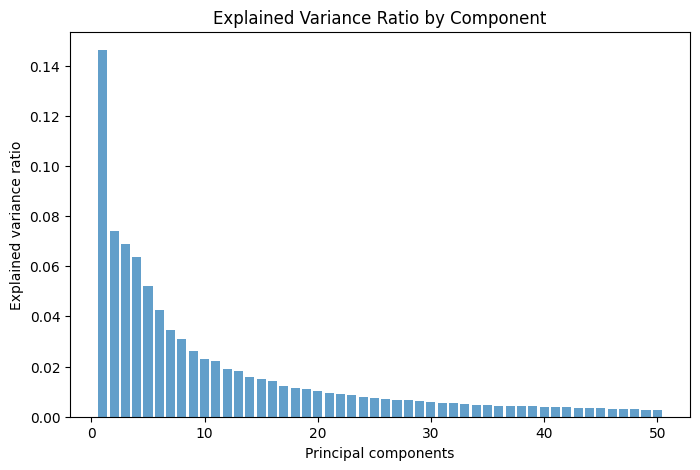

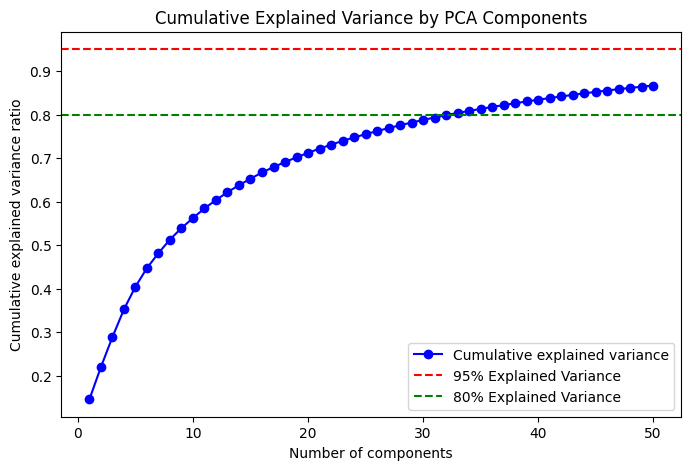

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_df)
pca = PCA(n_components=50)

embeddings_pca = pca.fit_transform(embeddings_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio by Component')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Number of components')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% Explained Variance')
plt.legend(loc='best')
plt.show()


In [163]:
pca = PCA(n_components=3)

embeddings_pca = pca.fit_transform(embeddings_scaled)

In [164]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoded_ids = encoder.fit_transform(df[['MKT_BASE_CAMPGN_ID', 'PARENT_MKT_CAMPGN_ID', 'MKT_CAMPGN_ID']]).toarray()

encoded_ids_df = pd.DataFrame(encoded_ids, columns=encoder.get_feature_names_out())

combined_df = pd.concat([encoded_ids_df, pd.DataFrame(embeddings_pca)], axis=1)



In [165]:
combined_df.columns = combined_df.columns.astype(str)

scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_df)


In [166]:
from sklearn.cluster import KMeans

def elbow_method(data, max_k):
    wcss = []  # Within-cluster sum of squares
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, max_k + 1), wcss, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.show()

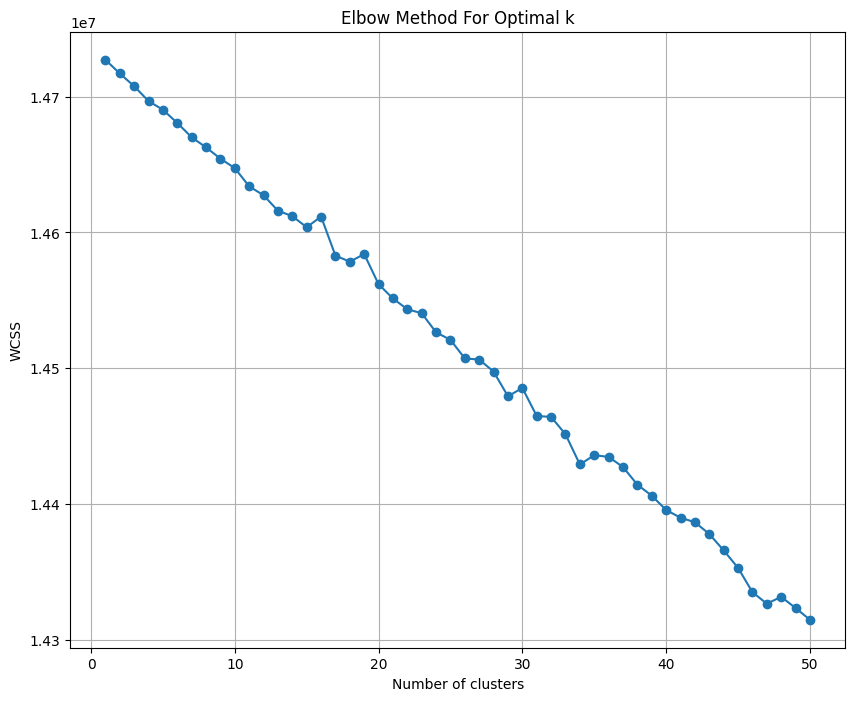

In [141]:
elbow_method(combined_scaled, 50)


In [171]:
# Initialize KMeans
ncluster = 5
kmeans = KMeans(n_clusters=ncluster, random_state=42)  

kmeans.fit(embeddings_df)  

# Add the cluster labels to your DataFrame
df['Cluster'] = kmeans.labels_


In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_texts(texts):
    return [str(text) if text is not None else "" for text in texts]

def get_top_terms(texts, top_n=10):
    if not texts:  
        return []
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(tfidf_matrix.sum(axis=0)).flatten()[::-1]
    top_terms = feature_array[tfidf_sorting][:top_n]
    return top_terms.tolist()


In [169]:
top_terms_by_cluster = {i: get_top_terms(clustered_texts_sub[i]) for i in range(ncluster)}

top_terms_by_cluster

{0: [['pro', 'complimentari', 'enjoy', 'platinum', 'statu', 'today']],
 1: [['appli', 'bonu', 'mile', 'miss', 'offer', 'preselect']],
 2: [['admir', 'club', 'membership', 'renew', 'time']],
 3: [['aadvantag',
   'admir',
   'citi',
   'club',
   'complimentari',
   'forget',
   'loung',
   'pas',
   'use']],
 4: [['experi', 'revit', 'travel', 'welcom']]}

In [172]:
df['Cluster'].value_counts()

Cluster
0    1041
4     935
2     418
3     298
1     282
Name: count, dtype: int64

/tmp/ipykernel_332273/3436816065.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=np.log(df['WEIGHTED_LYLTY_LINK_CLICK_RATE']), data=df, palette='cool')


<Axes: xlabel='Cluster', ylabel='WEIGHTED_LYLTY_LINK_CLICK_RATE'>

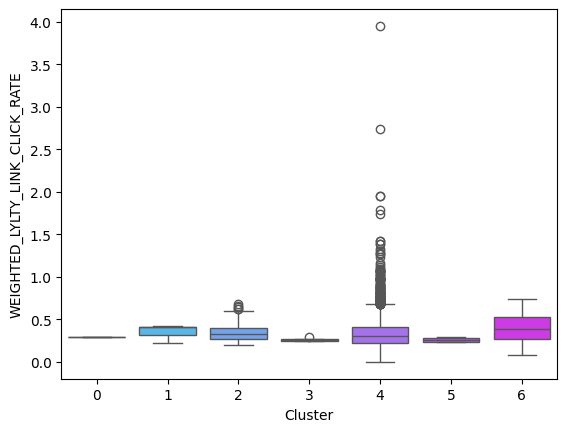

In [38]:
sns.boxplot(x='Cluster', y=np.log(df['WEIGHTED_LYLTY_LINK_CLICK_RATE']), data=df, palette='cool')  


/tmp/ipykernel_332273/1561517925.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=np.log(df['WEIGHTED_ALL_LINK_CLICK_RATE']), data=df, palette='cool')


<Axes: xlabel='Cluster', ylabel='WEIGHTED_ALL_LINK_CLICK_RATE'>

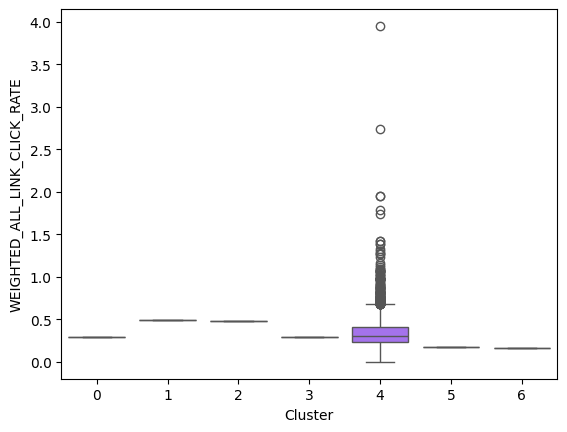

In [109]:
sns.boxplot(x='Cluster', y=np.log(df['WEIGHTED_ALL_LINK_CLICK_RATE']), data=df, palette='cool')  


/tmp/ipykernel_332273/1390103872.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='AVG_RESPONSE_TIME', data=df, palette='cool')


<Axes: xlabel='Cluster', ylabel='AVG_RESPONSE_TIME'>

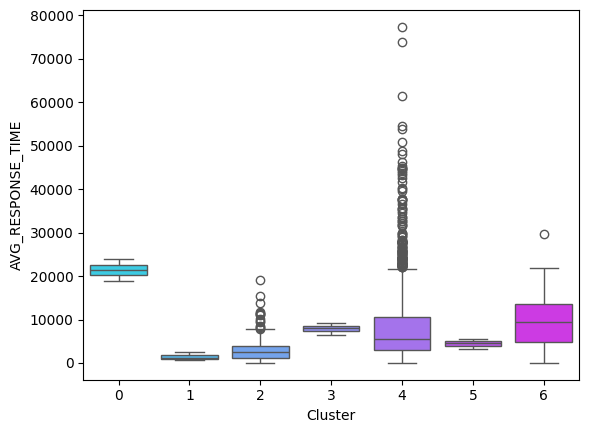

In [39]:
sns.boxplot(x='Cluster', y='AVG_RESPONSE_TIME', data=df, palette='cool')  


/tmp/ipykernel_332273/886504472.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='WEIGHTED_ALL_LINK_CLICK_RATE', data=df, palette='cool')


<Axes: xlabel='Cluster', ylabel='WEIGHTED_ALL_LINK_CLICK_RATE'>

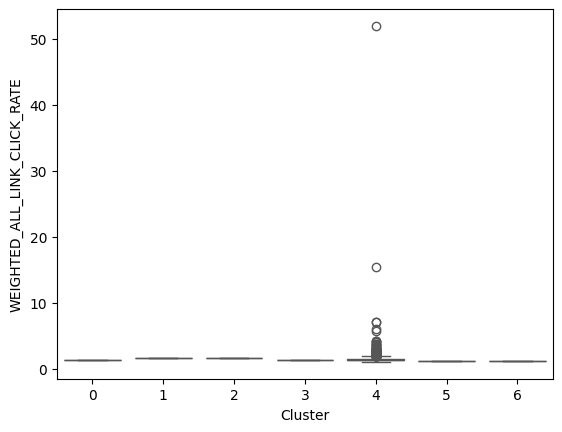

In [108]:
sns.boxplot(x='Cluster', y='AVG_ENGAGEMENT_DURATION', data=df, palette='cool')  


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 0 to 2973
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MKT_BASE_CAMPGN_ID              2974 non-null   int64  
 1   PARENT_MKT_CAMPGN_ID            2974 non-null   int64  
 2   MKT_CAMPGN_ID                   2974 non-null   int64  
 3   CAMPGN_SUBJCT_LINE_TXT          2974 non-null   object 
 4   WEIGHTED_LYLTY_LINK_CLICK_RATE  2974 non-null   float64
 5   WEIGHTED_ALL_LINK_CLICK_RATE    2974 non-null   float64
 6   AVG_RESPONSE_TIME               2974 non-null   float64
 7   AVG_ENGAGEMENT_DURATION         2974 non-null   float64
 8   preprocessed_text               2974 non-null   object 
 9   Cluster                         2974 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(2)
memory usage: 220.9+ KB


In [110]:
cluster_means = df.groupby('Cluster')[['WEIGHTED_LYLTY_LINK_CLICK_RATE', 'WEIGHTED_ALL_LINK_CLICK_RATE', 'AVG_RESPONSE_TIME', 'AVG_ENGAGEMENT_DURATION']].mean()

# Calculate standard deviation for each cluster
cluster_std = df.groupby('Cluster')[['WEIGHTED_LYLTY_LINK_CLICK_RATE', 'WEIGHTED_ALL_LINK_CLICK_RATE', 'AVG_RESPONSE_TIME', 'AVG_ENGAGEMENT_DURATION']].std()

print("Cluster Means:\n", cluster_means)
print("\nCluster Standard Deviations:\n", cluster_std)

Cluster Means:
          WEIGHTED_LYLTY_LINK_CLICK_RATE  WEIGHTED_ALL_LINK_CLICK_RATE  \
Cluster                                                                 
0                              1.340431                      1.340431   
1                              1.634518                      1.634518   
2                              1.625571                      1.625571   
3                              1.344162                      1.344162   
4                              1.461109                      1.461109   
5                              1.192557                      1.192557   
6                              1.173077                      1.173077   

         AVG_RESPONSE_TIME  AVG_ENGAGEMENT_DURATION  
Cluster                                              
0             21396.019737             40813.246345  
1             13290.783784             31349.608108  
2               827.000000             37084.500000  
3             10375.490616             38623.528739  
4 

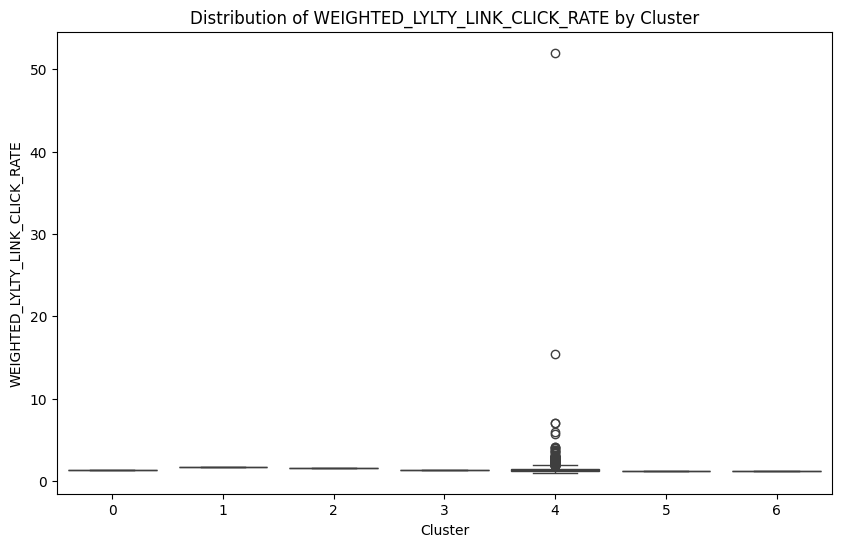

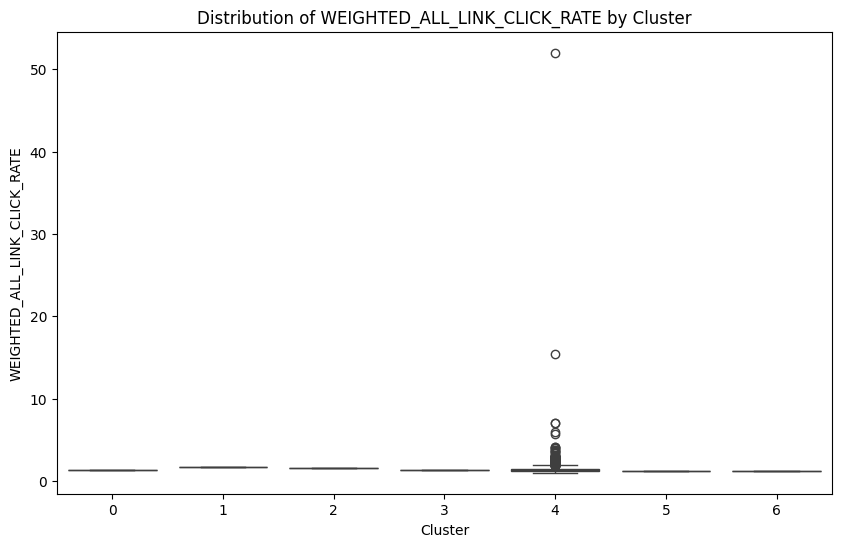

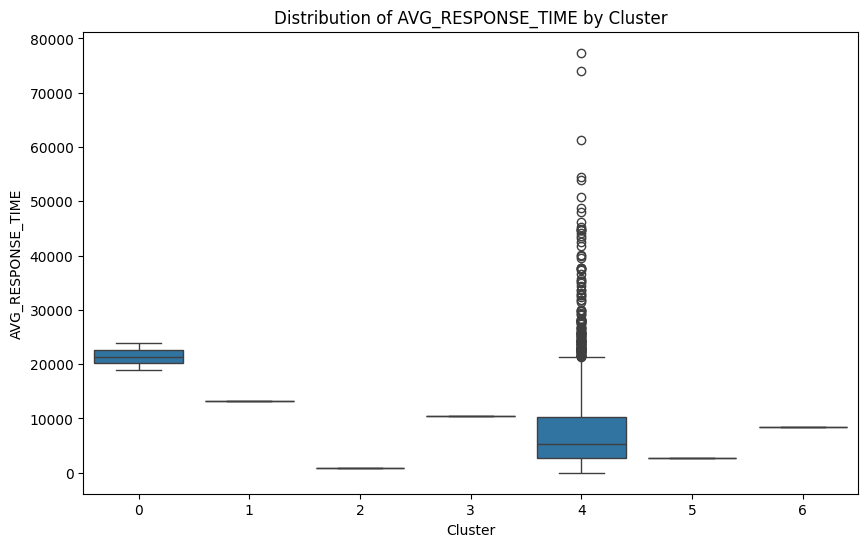

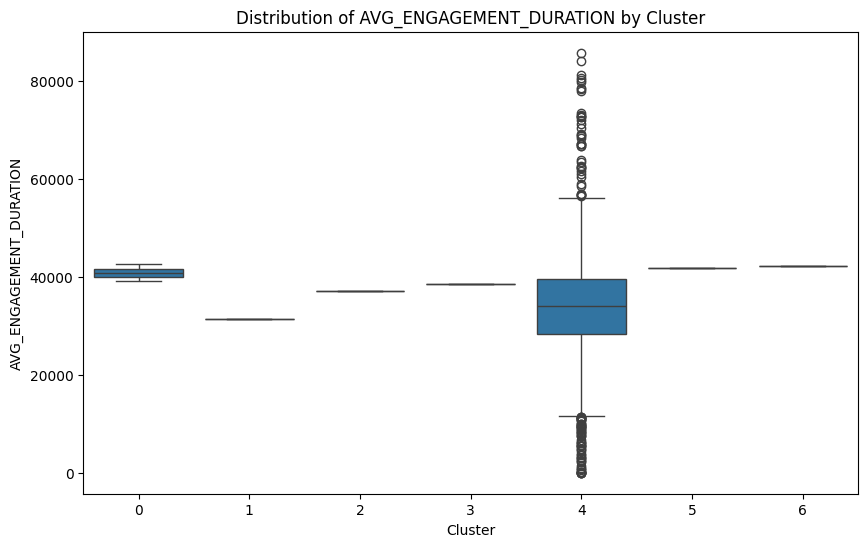

In [111]:
for column in ['WEIGHTED_LYLTY_LINK_CLICK_RATE', 'WEIGHTED_ALL_LINK_CLICK_RATE', 'AVG_RESPONSE_TIME', 'AVG_ENGAGEMENT_DURATION']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=df)
    plt.title(f'Distribution of {column} by Cluster')
    plt.show()